In [1]:
%matplotlib inline
try:
    import cPickle as pickle
except:
    import pickle
import multiprocessing
import json
import math
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import pywt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from collections import Counter
from sklearn.decomposition import PCA
import random

In [2]:
def SaveDataFrame(df,picklefile):
    pickle.dump(df,open(picklefile,'w+'))
def LoadDataFrame(picklefile):
    superdf = pickle.load(open(picklefile))
    return superdf
def ObtainSessionData(df,user,session,date):
    return df[df.apply(lambda x:x['User'] == user and x['Session'] == session and x['Day'] == date,axis=1)]
def ObtainSmoothness(df):
    users = df['User'].values
    sessions = df['Session'].values
    days = df['Day'].values
    velocities = df['Speed'].values
    i,mincost,mincostidx = 0,0,0
    while users[i+1] == users[i] and sessions[i+1] == sessions[i] and days[i+1] == days[i]:
        mincost = mincost + (velocities[i+1]-velocities[i])**2
        i = i + 1
    mincostidx = i
    mincost = mincost * 1.0/(i+1)
    cost = 0
    i,lastidx = i+1,i+1
    while i < len(users) - 1:
        if users[i+1] == users[i] and sessions[i+1] == sessions[i] and days[i+1] == days[i]:
            cost = cost + (velocities[i+1]-velocities[i])**2
        else:
            cost = cost * (1.0/(i+1-lastidx))**0.5
            if cost < mincost:
                mincost = cost
                mincostidx = i
            lastidx = i
            cost = 0
        i = i + 1
    cost = cost * (1.0/(i+1-lastidx))**0.5
    #print cost,i+1-lastidx
    print sessions[mincostidx]
    if cost < mincost:
        mincost = cost
        mincostidx = i
    return (users[mincostidx],sessions[mincostidx],days[mincostidx])

In [47]:
def distance_on_unit_sphere(lat1, long1, lat2=48.787980, long2=11.381053):
        # Convert latitude and longitude to 
        # spherical coordinates in radians.
        #if np.isnan(lat1) or np.isnan(long1) or np.isnan(lat2) or np.isnan(long2):
        #   return 10**6
        degrees_to_radians = math.pi/180.0
        # phi = 90 - latitude
        phi1 = lat1*degrees_to_radians
        phi2 = lat2*degrees_to_radians
        # theta = longitude
        theta1 = long1*degrees_to_radians
        theta2 = long2*degrees_to_radians
        # Compute spherical distance from spherical coordinates.
        cos = math.sin(phi1)*math.sin(phi2) + math.cos(phi1)*math.cos(phi2)*math.cos(theta2-theta1)
        if abs(cos) < 1:
                arc = math.acos( cos )
        else:
                arc = 0
        return arc*3960 #Miles
def CreateDataFrameWrapper(info_tuple):
    return CreateDataFrame(lat=info_tuple[0],long=info_tuple[1],heading_start=info_tuple[2],heading_end=info_tuple[3])

def CreateDataFrame(lat=48.787980,long=11.381053,radius=100,heading_start=270.0,heading_end=360.0,heading_tol=20):
        global users
        global userid
        radius = (radius)/5280.0
        dataframes = []
        #heading_start,heading_end = min(heading_start,heading_end),max(heading_start,heading_end)
        columns = ['Day','Time']
        with open('snapshots/usefulsig_copy') as fp:
            for line in fp:
                columns.append(line.strip().split()[1]) 
        print columns
        for user in users:
                simpleId = userid[user]
                #if simpleId not in ['6','12','10','50','45']:
                if simpleId not in ['10','57','45','36','27']:
                    continue
                allDates = users[user]
                usertimeinfo = {}
                userfeatures = {}
                for date in allDates:
                        userDir = '/dfs/scratch0/abhisg/new_data/'+simpleId+'/'+date+'/'
                        files = sorted(os.listdir(userDir))
                        session = 0
                        for file in files:
                                if os.stat(userDir+file).st_size > 0:
                                        #print userDir+file
                                        df = pd.read_csv(userDir+file,delim_whitespace=True,header=None).dropna()
                                        if df.shape[0] == 0: #highly unlikely but a failsafe check
                                            continue
                                        df.columns = columns
                                        #df.columns = ["Day", "Time", "Steer_Angle", "Velocity", "Heading", "Latitude", "Longitude", "Brightness", "Road_Type", \
                                        #        "Num_Oncoming_Lanes", "Curr_Seg_ID", "Seg_Dist_Left", "Next_Seg_ID", "Steer_Velocity", "Brake", "Pedal", "Fuel", "X_Accel", \
                                        #        "Y_Accel", "Mileage", "RPM", "Wiper_Speed", "Time2Coll", "Deacc_Request", "L_Sig", "R_Sig"]
                                        df['Distance'] = df.apply(lambda x:distance_on_unit_sphere(x['Latitude'],x['Longitude'],lat,long),axis=1)
                                        #modular arithmetic crap. Need to distinguish SE,NW,WN and ES turns from the directions flipped
                                        df = df[df.apply(lambda x:x['Distance'] <= radius,axis=1)]
                                        if df.shape[0] == 0:
                                            print "No data found for", user,date,file
                                            continue
                                        listOfIndices = df.index
                                        startindex,endindex = 0,1
                                        while endindex < len(listOfIndices):
                                            if listOfIndices[endindex] - listOfIndices[endindex-1] > 100: #discontinuity;session jump
                                                startHeading,endHeading = df['Heading'].iloc[startindex],df['Heading'].iloc[endindex-1]
                                                #print startHeading,endHeading
                                                if ((startHeading >= heading_start - heading_tol and startHeading <= heading_start + heading_tol) or\
                                                    startHeading >= heading_start + 360 - heading_tol or startHeading <= heading_start - 360 + heading_tol) and\
                                                    ((endHeading >= heading_end - heading_tol and endHeading <= heading_end + heading_tol) or\
                                                    startHeading >= heading_end + 360 - heading_tol or endHeading <= heading_end - 360 + heading_tol):
                                                        df_subset = df[np.logical_and(df.index >= listOfIndices[startindex],df.index < listOfIndices[endindex])]
                                                        df_subset['User'] = pd.Series(np.repeat(simpleId,df_subset.shape[0]),index=df_subset.index)
                                                        df_subset['Session'] = pd.Series(np.repeat(session,df_subset.shape[0]),index=df_subset.index)
                                                        for i in xrange(1,len(df_subset['Heading'].values)):
                                                            if df_subset['Heading'].iloc[i] > df_subset['Heading'].iloc[i-1] + 300:
                                                                df_subset['Heading'].iloc[i] -= 360
                                                            elif df_subset['Heading'].iloc[i] < df_subset['Heading'].iloc[i-1] - 300:
                                                                df_subset['Heading'].iloc[i] += 360
                                                        print simpleId,date,session,df_subset['Heading'].iloc[0]\
                                                            ,df_subset['Heading'].iloc[-1],listOfIndices[startindex],listOfIndices[endindex-1],df_subset.shape,df_subset['Latitude'].iloc[0],df_subset['Longitude'].iloc[0],df_subset['Latitude'].iloc[df_subset.shape[0]-1],df_subset['Longitude'].iloc[df_subset.shape[0]-1]
                                                        dataframes.append(df_subset)
                                                        startindex = endindex
                                                        session = session + 1
                                            endindex = endindex + 1
                                        startHeading,endHeading = df['Heading'].iloc[startindex],df['Heading'].iloc[endindex-1]
                                        if ((startHeading >= heading_start - heading_tol and startHeading <= heading_start + heading_tol) or\
                                            startHeading >= heading_start + 360 - heading_tol or startHeading <= heading_start - 360 + heading_tol) and\
                                            ((endHeading >= heading_end - heading_end and endHeading <= heading_end + heading_tol) or\
                                            startHeading >= heading_end + 360 - heading_tol or endHeading <= heading_end - 360 + heading_tol):
                                                df_subset = df[np.logical_and(df.index >= listOfIndices[startindex],df.index <= listOfIndices[endindex-1])]
                                                df_subset['User'] = pd.Series(np.repeat(simpleId,df_subset.shape[0]),index=df_subset.index)
                                                df_subset['Session'] = pd.Series(np.repeat(session,df_subset.shape[0]),index=df_subset.index)
                                                for i in xrange(1,len(df_subset['Heading'].values)):
                                                    if df_subset['Heading'].iloc[i] > df_subset['Heading'].iloc[i-1] + 300:
                                                        df_subset['Heading'].iloc[i] -= 360
                                                    elif df_subset['Heading'].iloc[i] < df_subset['Heading'].iloc[i-1] - 300:
                                                        df_subset['Heading'].iloc[i] += 360
                                                print simpleId,date,session,df_subset['Heading'].iloc[0]\
                                                    ,df_subset['Heading'].iloc[-1],listOfIndices[startindex],listOfIndices[endindex-1],df_subset.shape,df_subset['Latitude'].iloc[0],df_subset['Longitude'].iloc[0],df_subset['Latitude'].iloc[df_subset.shape[0]-1],df_subset['Longitude'].iloc[df_subset.shape[0]-1]
                                                dataframes.append(df_subset)
                                                startindex = endindex
                                                session = session + 1
                                        else:
                                            x = 10
                                            #print "No match found : Start heading",startHeading,"End heading",endHeading

        if len(dataframes) > 0:
            return pd.concat(dataframes,axis=0)
        else:
            return []

In [48]:
def CreateAlignment(superdf,userid=None,sessionid=None,scheme=1):
        if scheme == 1:
                return AlignmentByLatLong(superdf,userid,sessionid)
            
def AlignmentByLatLong(superdf,userid=None,sessionid=None,date=None):
        random.seed(1)
        #featurecolumns = ["Steer_Angle", "Velocity", "Heading",  \
        #                    "Steer_Velocity", "Brake", "Pedal",\
        #                    "X_Accel", "Y_Accel", "RPM"]
        signature = superdf[['User','Session','Day']].drop_duplicates()
        """if userid is None or userid not in signature['User'] or sessionid is None or sessionid not in signature['Session'] or date is None or date not in signature['Day']:
                duplicates = superdf.groupby(['User','Day','Session']).size()
                duplicates_dataframe = duplicates.reset_index()
                minidx,mincost = 0,ObtainSmoothness(superdf[superdf.apply(lambda x:x['User'] == \
                                                       duplicates_dataframe['User'].iloc[0]\
                                                        and x['Session'] == duplicates_dataframe['Session'].iloc[0] \
                                                        and x['Day'] == duplicates_dataframe['Day'].iloc[0],axis=1)])
                #minidx,mincost = 0,ObtainSmoothness(duplicates_dataframe.iloc[[0]])
                for i in xrange(1,len(duplicates)):
                    cost = ObtainSmoothness(superdf[superdf.apply(lambda x:x['User'] == \
                                                        duplicates_dataframe['User'].iloc[i]\
                                                        and x['Session'] == duplicates_dataframe['Session'].iloc[i] \
                                                        and x['Day'] == duplicates_dataframe['Day'].iloc[i],axis=1)])
                    #cost = ObtainSmoothness(duplicates_dataframe.iloc[[i]])
                    print cost
                    if cost < mincost:
                        minidx,mincost = i,cost
                #counts = sorted([(i,duplicates.iloc[i]) for i in xrange(len(duplicates))],key=lambda x:x[1])
                #minidx = random.choice(counts[0:int(0.1*len(counts))])[0]
                #trials = 0
                #while trials < 100 and duplicates.iloc[minidx] < 100: #choose parameters intelligently
                #    minidx = random.choice(counts[0:int(0.1*len(counts))])[0]
                #    trials = trials + 1
                #print "Picked index",minidx,"with state size",duplicates.iloc[minidx]"""
                #userid,sessionid,date = duplicates_dataframe['User'].iloc[minidx],duplicates_dataframe['Session'].iloc[minidx],\
                #duplicates_dataframe['Day'].iloc[minidx]
        #userid,sessionid,date='35',0,'2014-05-05'
        
        features = []
        with open('snapshots/usefulsig') as fp:
            for line in fp:
                line = line.strip().split()[-1]
                if line != 'Latitude' and line != 'Longitude':
                    features.append(line)
        userid,sessionid,date = ObtainSmoothness(superdf)
        print "Picked user",userid,"session",sessionid,"date",date
        #define the benchmark lat long values and the corresponding distance matrix
        gdist = []
        df = superdf[superdf.apply(lambda x:x['User'] == userid and x['Session'] == sessionid and date == x['Day'],axis=1)]
        gdist,lat_baseline,long_baseline = -df['Distance'].values,df['Latitude'].values,df['Longitude'].values
        for i in xrange(1,gdist.shape[0]):
                gdist[i] = gdist[i-1] + distance_on_unit_sphere(lat_baseline[i],long_baseline[i],lat_baseline[i-1],long_baseline[i-1])
        dataframes = []
        #loop over all unique sessions and add the aligned dataframe to the list of dataframes
        for idx in xrange(signature.shape[0]):
            user,session,day = signature['User'].iloc[idx],signature['Session'].iloc[idx],signature['Day'].iloc[idx]
            #if user not in ['6','45','50','47','54']:
            #    continue
            df = superdf[superdf.apply(lambda x:x['User'] == user and x['Session'] == session and day == x['Day'],axis=1)]
            if df.shape[0] == 0:
                continue
            baseline = df.index[0]
            if user != userid or session != sessionid or day != date:
                    retain = []
                    i,targetidx = 1,0
                    dist,lat,long = -df['Distance'].values,df['Latitude'].values,df['Longitude'].values
                    while i < len(lat) and dist[i-1] < gdist[targetidx]:
                        i = i + 1
                    if i > 1:
                        i = i - 1
                    if i < len(lat):
                        retain.append(baseline+i-1)
                        distance,targetidx = dist[i-1],targetidx+1
                    else:
                        continue
                    #print i,dist[i-1],gdist[targetidx-1]
                    while i < len(lat)-1 and targetidx < gdist.shape[0]:        
                        curdist = distance + distance_on_unit_sphere(lat[i],long[i],lat[i-1],long[i-1])
                        nextdist = curdist + distance_on_unit_sphere(lat[i+1],long[i+1],lat[i],long[i])
                        if curdist == gdist[targetidx] or (curdist < gdist[targetidx] and nextdist > gdist[targetidx]):
                            retain.append(baseline+i)
                            targetidx,distance,i = targetidx + 1,curdist,i+1
                        elif curdist > gdist[targetidx] :
                            retain.append(baseline+max(i-1,0))
                            targetidx = targetidx + 1
                        else:
                            distance,i = curdist,i+1
                    #fill in the remaining values with the last recorded instance
                    while targetidx < gdist.shape[0]:
                        retain.append(baseline+len(lat)-1)
                        targetidx = targetidx + 1
                    #keep only the indices which correspond to the alignment
                    #original_df = df
                    retain = np.array(retain)
                    df = df.loc[retain]
                    #interpolate the features
                    #retain -= baseline
                    #for i in xrange(len(retain)):
                    #    try:
                    #        dist1 = distance_on_unit_sphere(lat_baseline[i],long_baseline[i],lat[retain[i]],long[retain[i]])
                    #        dist2 = distance_on_unit_sphere(lat_baseline[i],long_baseline[i],lat[retain[i]+1],long[retain[i]+1])
                    #    except:
                    #        continue
                    #    for feature in features:
                    #        df[feature].iloc[i] = dist2*1.0/(dist1+dist2)*original_df[feature].iloc[retain[i]] +\
                    #                            dist1*1.0/(dist1+dist2)*original_df[feature].iloc[retain[i]+1]
                            
            if df.shape[0] > 0:
                df['State'] = pd.Series(np.arange(df.shape[0]),index=df.index)
                print idx,user,session,day,df['Time'].iloc[0],df['Time'].iloc[-1]
                dataframes.append(df)
            else:
                continue
        return pd.concat(dataframes,axis=0)

In [49]:
def FeaturesForClassifier(superdf,featurecolumns,simplestatistics=True,complexstatistics=True,rawfeatures=False,users=None):
    signature = superdf[['User','Session','Day']].drop_duplicates()
    #print signature.loc[signature['User'].isin(users)]
    if users is not None:
        signature = signature.loc[signature['User'].isin(users)]
    states = superdf['State'].drop_duplicates()
    features,labels,labelcount = [],[],0
    if complexstatistics == True:
        appxfeatures = [[] for col in featurecolumns]
        detailfeatures = [[] for col in featurecolumns]
    if rawfeatures == True:
        rfeatures = [[] for col in featurecolumns]
    #print signature.shape[0]
    for i in xrange(signature.shape[0]):
        df = ObtainSessionData(superdf,signature['User'].iloc[i],signature['Session'].iloc[i],signature['Day'].iloc[i])
        if df.shape[0] == 0: #wrong values have crept in. Debug
            continue
        #if min(df['Velocity']) < 10: #remove sessions with stationarity
        #    continue
        #simple features are yanked from the time series 'as is'. Complex features are obtained from DWT of the time series
        currentsimplefeatures = []
        serieslists = []
        for j,col in enumerate(featurecolumns):
            if df[col].dtype != object:
                series = df[col].values
            else:
                series = np.array([0 if val == 'f' else 1 for val in df[col].values])
            serieslists.append(series)
            if rawfeatures == True:
                rfeatures[j].append(series)
            else:
                if simplestatistics == True:
                    currentsimplefeatures = currentsimplefeatures +  [np.mean(series),np.std(series),np.min(series),np.max(series),\
                                                                      scipy.stats.skew(series),\
                                                  scipy.stats.kurtosis(series),scipy.signal.correlate(series,series)[0]]
                if complexstatistics == True:
                    appx,detail = pywt.dwt(series,'haar')
                    appxfeatures[j].append(appx)
                    detailfeatures[j].append(detail)
        #if simplestatistics == True:
        #    for j in xrange(len(serieslists)):
        #        for k in xrange(j+1,len(serieslists)):
        #            currentsimplefeatures = currentsimplefeatures + [scipy.signal.correlate(serieslists[j],serieslists[k])[0]]
        print signature['User'].iloc[i],signature['Session'].iloc[i],signature['Day'].iloc[i]
        features.append(currentsimplefeatures)
        labels.append(int(signature['User'].iloc[i]))
    if complexstatistics == True and rawfeatures == False:
        pca_model = PCA(n_components = min(5,len(appxfeatures[j])))
        for j in xrange(len(featurecolumns)):
            #minlen1,minlen2 = min([len(elem) for elem in appxfeatures[j]]),min([len(elem) for elem in detailfeatures[j]])
            #for k in xrange(len(appxfeatures[j])):
            #    appxfeatures[j][k] = appxfeatures[j][k][:minlen1]
            #for k in xrange(len(detailfeatures[j])):
            #    detailfeatures[j][k] = detailfeatures[j][k][:minlen2]
            appxfeatures[j] = pca_model.fit_transform(appxfeatures[j])
            detailfeatures[j] = pca_model.fit_transform(detailfeatures[j])
            for k in xrange(len(features)):
                features[k] = features[k] + appxfeatures[j][k].tolist() + detailfeatures[j][k].tolist()
    elif rawfeatures == True:
        pca_model = PCA(n_components=5)
        for j in xrange(len(featurecolumns)):
            rfeatures[j] = pca_model.fit_transform(rfeatures[j])
            for k in xrange(len(features)):
                features[k] = features[k] + rfeatures[j][k].tolist()
                #print k,len(features[k])
    #features = np.array(features)
    print len(features)
    return np.column_stack((features,labels))

def ClassificationPipeline(superdf=None,featurecolumns=None,loadfile=False,savefile=True,simplestatistics=True,complexstatistics=True,classifier='RandomForest',filename=None,users=None):
    if loadfile == True:
        if filename is None:
            print "Must specify pickle file containing the data"
            return
        data = pickle.load(open(filename))
    else:
        if simplestatistics == False and complexstatistics == False:
            print "No statistics have been specified!"
            return
        if superdf is None:
            print "Cannot proceed without a dataframe to work on !"
            return
        if featurecolumns is None:
            featurecolumns = ["Steer_Angle", "Velocity", "Heading", "Brightness", "Road_Type", "Num_Oncoming_Lanes", \
                              "Curr_Seg_ID", "Seg_Dist_Left", "Next_Seg_ID", "Steer_Velocity", "Brake", "Pedal",\
                              "Fuel", "X_Accel", "Y_Accel", "Mileage", "RPM", "Wiper_Speed", "Time2Coll", "Deacc_Request"]
        data = FeaturesForClassifier(superdf,featurecolumns,simplestatistics,complexstatistics,users)
        if savefile == True:
            if filename is not None:
                pickle.dump(data,open(filename,'w+'))
                print "Data saved for future reference"
            else:
                print "Cannot save data since filename has not been specified"
    features,labels = data[:,:-1],data[:,-1]
    #print features.shape
    if users is None:
        users = map(int,np.unique(labels))
    else:
        users = map(int,users)
    print users
    idx = []
    for i in xrange(len(labels)):
        if labels[i] in users:
            idx.append(i)
    idx = np.array(idx)
    data_X,data_Y = features[idx,:],labels[idx]
    #cvobj = StratifiedKFold(data_Y,n_folds=10)
    cvobj = StratifiedShuffleSplit(data_Y,n_iter=100,random_state=1,test_size=len(users))
    actual,predictions=[],[]
    percentage = [{user:0 for user in users} for idx in xrange(len(data_Y))]
    #importance = np.zeros((data_X.shape[1]/37,1))
    for train_idx,test_idx in cvobj:
        if classifier == 'RandomForest':
            counts = Counter(data_Y[train_idx])
            sample_weight = [1-counts[data_Y[idx]]*1./len(train_idx) for idx in train_idx]
            model = RandomForestClassifier(n_estimators=100,class_weight='subsample',\
                                           criterion='entropy',max_features=0.66,\
                                           random_state=1,n_jobs=-1)
            model.fit(data_X[train_idx,:],data_Y[train_idx],sample_weight=None)
            #importances = sorted([(i,model.feature_importances_[i]) for i in xrange(len(model.feature_importances_))],key = lambda x:x[1],reverse=True)[0:50]
            #for i in xrange(len(importances)):te
            #    idx = importances[i][0]/37    #parameterise this stuff
            #    importance[idx] = importance[idx] + 1.0/(i+1)
        elif classifier == "MultinomialRegression":
            model = LogisticRegression(class_weight='auto')
            model.fit(data_X[train_idx,:],data_Y[train_idx])
        else:
            model = SVC(kernel='linear')
            model.fit(data_X[train_idx,:],data_Y[train_idx])
        actual = actual + data_Y[test_idx].tolist()
        predictions = predictions + model.predict(data_X[test_idx,:]).tolist()
        newpreds = model.predict(data_X[test_idx,:])
        for i in xrange(len(test_idx)):
            percentage[test_idx[i]][newpreds[i]] = percentage[test_idx[i]][newpreds[i]] + 1
        print confusion_matrix(actual,predictions,users)
    for i in xrange(len(data_Y)):
        print data_Y[i],percentage[i]
    #print importance
    #plt.bar(list(xrange(importance.shape[0])),importance)
    #plt.show()
    print confusion_matrix(actual,predictions,users)
    plt.imshow(confusion_matrix(actual,predictions,users), interpolation='nearest')
    plt.show()        
    
def ClusteringPipeline(data_X,data_Y,users,n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters)
    data_X = (data_X-numpy.min(data_X,axis=0))/(numpy.max(data_X,axis=0)-numpy.min(data_X,axis=0))
    kmeans.fit(data_X)
    classfrequency = [[0 for label in users] for i in xrange(n_clusters)]
    for i in xrange(data_X.shape[0]):
        label = int(data_Y[i])
        if label in users:
            predictedcluster,label = kmeans.predict(data_X[i])[0],int(data_Y[i])
            classfrequency[predictedcluster][users.index(label)] = classfrequency[predictedcluster][users.index(label)] + 1
    classfrequency = np.array(classfrequency,dtype=float)
    #print classfrequency
    classfrequency /= 1.0*sum(classfrequency)
    #print classfrequency
    colors = ['b','g','r','c','m','y','k']
    width = 0.75/len(users)
    axis = np.array(xrange(classfrequency.shape[0]))
    for i in xrange(classfrequency.shape[1]):
        plt.bar((width)*i+axis,classfrequency[:,i],color=colors[(i+1)%len(colors)],width=width)
    plt.xlabel("Clusters")
    plt.ylabel("User Fraction")
    plt.show()
    
    #distribution = []
    #for label in users:
    #    distribution.append(max(classfrequency[users.index(label)][0],classfrequency[users.index(label)][1])*1.0/sum(classfrequency[users.index(label)]))
    #width = 1./n_clusters
    
    #plt.bar(users,distribution)
    #plt.xlabel('Label')
    #plt.ylabel('Distribution')
    #plt.show()
        
        
    

In [50]:
def plotUser(superdf,user,feature,sessions=None,days=None):
    df = superdf[superdf.apply(lambda x:x['User'] == user,axis=1)]
    if df.shape[0] == 0:
        print "No such user exists in the database"
        return
    #sessiondaytuple = df[['Session','Day']].drop_duplicates()
    sessionlist,daylist = df['Session'].drop_duplicates(),df['Day'].drop_duplicates()
    if sessions is not None:
        sessionlist = sessions
    if days is not None:
        daylist = days
    for session in sessionlist:
        for day in daylist:
            currentdf = df[df.apply(lambda x:x['Day'] == day and x['Session'] == session,axis=1)]
            #print currentdf
            if currentdf.shape[0] > 0:
                if currentdf[feature].dtype != object:
                    plt.plot(currentdf[feature])
                else:
                    plt.plot([0 if val=='f' else 1 for val in currentdf[feature]])
            else:
                print day,session,"This day,session combination does not exist"
    plt.ylabel(feature)
    plt.xlabel('Ground Truth Points')
    plt.show()
    
def plotComparison(superdf,feature,users,sessioninfo):
    colors = ['b','g','r','c','m','y','k']
    for i in xrange(len(users)):
        print i
        for session,day in sessioninfo[i]:
            df = superdf[superdf.apply(lambda x:x['User'] == users[i] and x['Day'] == day and x['Session'] == session,axis=1)]
            if df.shape[0] > 0:
                print colors[i%(len(colors))]
                plt.plot(df[feature],colors[i%(len(colors))])
    plt.xlabel('Ground Truth Points')
    plt.ylabel(feature)
    #plt.legend(users)
    plt.show()
    
    
def plotSession(superdf,user,day,session,featurelist=None):
    df = ObtainSessionData(superdf,user,session,day)
    if df.shape[0] == 0:
        print "Could not search for this information in the database"
        return
    features = ["Steer_Angle", "Steer_Velocity", "Brake", "Pedal", "X_Accel", "Y_Accel"]
    if featurelist is not None:
        features = featurelist
    df[features].plot()
    plt.show()

def plotFeature(superdf,feature,users=None,errorbar=False,statistic='mean'):
    userlist = superdf['User'].drop_duplicates()
    states = superdf['State'].drop_duplicates()
    if users is not None:
        userlist = users
    for user in userlist:
        df = superdf[superdf.apply(lambda x:x['User']==user,axis=1)]
        stat,error = [],[]
        for state in states:
            series = df[df.apply(lambda x:x['State']==state,axis=1)]
            if series[feature].dtype != object:
                newseries = series[feature].values
            else:
                newseries = np.array([0 if val == 'f' else 1 for val in series[feature].values])
            if statistic == 'mean':
                stat.append(np.mean(newseries))
            else:
                stat.append(np.median(newseries))
            error.append(np.std(newseries))
        print user,"done"
        if errorbar == True:
            plt.errorbar(states,stat,yerr=error)
        else:
            plt.plot(states,stat)
    plt.show()        
    

In [51]:
users = json.load(open('/dfs/scratch0/abhisg/granular_analysis/sessionsinfo.json'))
userid = {}
with open('/dfs/scratch0/abhisg/granular_analysis/user_id') as fp:
        for line in fp:
                line = line.strip().split()
                userid[line[0]] = line[1]

In [53]:
turn_list = [(48.789074, 11.381098 ,355,360),
             (48.789074, 11.381098 ,175,180),
             (48.774064, 11.405014, 215,250),
             (48.772316, 11.630630 , 175,180),
             (48.785444, 11.696363,120,140)]
#pool = multiprocessing.Pool(processes=5)
#dataframes = pool.map(CreateDataFrameWrapper,turn_list)
#for i in xrange(len(turn_list)):
#    try:
#        superdf = dataframes[i]
#        SaveDataFrame(superdf,'../data/frame_data/frame_'+str(turn_list[i][0])+'_'+str(turn_list[i][1])+\
#                      '_'+str(turn_list[i][2])+'_'+str(turn_list[i][3])+'_larger.pkl')
#    except:
#        print "empty value dataframe"
#48.772316_11.63063_175_180
#frame_48.774064_11.405014_215_250
dataframe = CreateDataFrame(lat=48.772316,long=11.63063,heading_start=175,heading_end=180,heading_tol=30)
SaveDataFrame(dataframe,'../data/frame_data/frame_48.774064_11.405014_260_270_larger.pkl')
dataframe = LoadDataFrame('../data/frame_data/frame_48.772316_11.63063_175_180_larger.pkl')
new_dataframe = CreateAlignment(dataframe)
SaveDataFrame(new_dataframe,'../data/frame_data/data_frame_48.772316_11.63063_175_180_aligned_larger.pkl')
new_dataframe = LoadDataFrame('../data/frame_data/data_frame_48.772316_11.63063_175_180_aligned_larger.pkl')
features = []
with open('snapshots/usefulsig') as fp:
    for line in fp:
        line = line.strip().split()[-1]
        if line != 'Latitude' and line != 'Longitude':
            features.append(line)
matrix = FeaturesForClassifier(new_dataframe,features,users=['10','57','45','36','27'],complexstatistics=True)
pickle.dump(matrix,\
open('../data/DataForClassification_final_simple_cross_longer_frame_48.772316_11.63063_175_180.pkl','w+'))
#superdf = CreateDataFrame()
#SaveDataFrame(superdf,'dfms.pkl')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['Day', 'Time', 'Latitude', 'Longitude', 'Brake', 'Steer_velocity', 'Human_momentum', 'X_accel', 'Y_accel', 'Speed', 'steering_wheel_angle', 'engine_rpm', 'Heading', 'absolute_pedal_position', 'absolute_throttle_position', 'lateral_acceleration', 'absolute_load_value']
10

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 2014-05-08 0 177.4 180.7 42721 42759 (39, 20) 48.772581 11.630604 48.772051 11.630623
10 2014-05-08 1 177.8 180.8 70149 70189 (41, 20) 48.772584 11.630635 48.772043 11.630651
10 2014-05-08 2 178.4 179.9 13249 13288 (40, 20) 48.772584 11.630627 48.772056 11.630642
10 2014-05-08 3 178.3 181.6 40204 40242 (39, 20) 48.772577 11.630592 48.772048 11.630607
10 2014-05-08 4 178.0 180.7 13020 13059 (40, 20) 48.772586 11.630584 48.772055 11.630599
10 2014-05-08 5 178.2 180.4 40548 40587 (40, 20) 48.772583 11.630556 48.772047 11.630579
10 2014-05-08 6 176.3 181.3 68713 68764 (52, 20) 48.77258 11.630588 48.772046 11.630636
10 2014-05-08 7 178.0 180.4 86293 86329 (37, 20) 48.772576 11.630557 48.772051 11.630579
No data found for ea5e4ec6-d005-41c0-84f2-0be84cec82c8 2014-04-29 snapshots_10_2014-04-29_8_0.dat
No data found for ea5e4ec6-d005-41c0-84f2-0be84cec82c8 2014-04-29 snapshots_10_2014-04-29_8_1.dat
No data found for ea5e4ec6-d005-41c0-84f2-0be84cec82c8 2014-04-29 snapshots_10_2014-04-29_8_2.d

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
#longer_dataframe = CreateDataFrame(lat=48.7880566803,long=11.3811085721,radius=400,heading_start=273.038461538,heading_end=355.841346154,heading_tol=20)
#SaveDataFrame(longer_dataframe,'../longer_frame_'+str(48.7880566803)+'_'+str(11.3811085721)+'_'+str(273.038461538)+'_'+str(355.841346154))
#48.7749571994_11.4171988121_181.069364162_89.4190751445
#48.7902749773_11.3816505382_25.1331444759_110.492917847
#48.7903583135_11.3814125959_288.018134715_197.365284974
#48.7880566803_11.3811085721_273.038461538_355.841346154
#48.7751719849_11.4096909879_338.271903323_249.725075529
#48.7366648289_11.4557780456_303.505703422_24.3346007605
#48.7743670484_11.4588970912_180.310541311_95.6495726496
#48.7741107493_11.4606530519_98.8443804035_174.878962536
#48.7746277879_11.6301796017_269.614718615_169.060606061
#48.7880144539_11.3811151809_178.508532423_91.2866894198
#48.6277094167_11.586373679_188.828947368_281.530701754
#48.7860322418_11.6941784725_4.94505494505_101.494505495

#straight roads
#48.774891_11.418878_89.4190751445_95.5
#48.789603_11.383646_115.492917847_118.5
#48.789490_11.383904_110.492917847_118.5
#48.737519_11.456390_24.3346007605_27.5
#48.767210_11.460066_174.878962536_177.5
#48.628199_11.583681_285_287
#
dataframe = CreateDataFrame(lat=48.789490,long=11.383904,heading_start=110.492917847,heading_end=118.5,heading_tol=20)
SaveDataFrame(dataframe,'../data/frame_data/frame_48.789490_11.383904_110.492917847_118.5_larger.pkl')
dataframe = LoadDataFrame('../data/frame_data/frame_48.789490_11.383904_110.492917847_118.5_larger.pkl')
new_dataframe = CreateAlignment(dataframe)
SaveDataFrame(new_dataframe,'../data/frame_data/data_frame_48.789490_11.383904_110.492917847_118.5_aligned_larger.pkl')
new_dataframe = LoadDataFrame('../data/frame_data/data_frame_48.789490_11.383904_110.492917847_118.5_aligned_larger.pkl')
features = []
with open('snapshots/usefulsig') as fp:
    for line in fp:
        line = line.strip().split()[-1]
        if line != 'Latitude' and line != 'Longitude':
            features.append(line)
matrix = FeaturesForClassifier(new_dataframe,features,users=['50','6','45','15','47'],complexstatistics=True)
pickle.dump(matrix,\
open('../data/DataForClassification_final_simple_cross_longer_frame_48.774891_11.418878_85.4190751445_95.5.pkl','w+'))
#ClassificationPipeline(loadfile=True,filename='../data/DataForClassification_V4_simple_cross_complex_nolim.pkl')ture

['Day', 'Time', 'Latitude', 'Longitude', 'Brake', 'Steer_velocity', 'Human_momentum', 'X_accel', 'Y_accel', 'Speed', 'steering_wheel_angle', 'engine_rpm', 'Heading', 'absolute_pedal_position', 'absolute_throttle_position', 'lateral_acceleration', 'absolute_load_value']
No data found for

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 bcc37725-fb79-4e4d-af83-69246a065228 2014-03-13 snapshots_6_2014-03-13_6_0.dat
6 2014-03-13 0 128.1 130.4 70476 70511 (36, 20) 48.789656 11.383605 48.789324 11.38422
No data found for bcc37725-fb79-4e4d-af83-69246a065228 2014-03-13 snapshots_6_2014-03-13_6_2.dat
No data found for bcc37725-fb79-4e4d-af83-69246a065228 2014-03-13 snapshots_6_2014-03-13_6_3.dat
No data found for bcc37725-fb79-4e4d-af83-69246a065228 2014-03-13 snapshots_6_2014-03-13_6_4.dat
No data found for bcc37725-fb79-4e4d-af83-69246a065228 2014-03-11 snapshots_6_2014-03-11_8_0.dat
No data found for bcc37725-fb79-4e4d-af83-69246a065228 2014-03-11 snapshots_6_2014-03-11_8_1.dat
6 2014-03-11 0 126.2 130.1 787 814 (28, 20) 48.789669 11.38359 48.789323 11.38423
No data found for bcc37725-fb79-4e4d-af83-69246a065228 2014-03-11 snapshots_6_2014-03-11_8_3.dat
6 2014-05-09 0 126.1 129.3 6259 6299 (41, 20) 48.78965 11.383567 48.789308 11.384206
6 2014-05-09 1 126.9 130.1 1340 1374 (35, 20) 48.789657 11.383588 48.789315 11.38421

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 2014-05-12 0 126.6 129.2 5024 5053 (30, 20) 48.789635 11.383562 48.789299 11.384193
15 2014-05-12 1 127.4 130.7 75508 75543 (36, 20) 48.78966 11.383603 48.789325 11.38423
No data found for ba289166-d8fb-48a6-8902-9a3603a7df32 2014-05-12 snapshots_15_2014-05-12_9_1.dat
15 2014-05-12 2 127.5 130.6 66849 66881 (33, 20) 48.789656 11.383591 48.789321 11.384212
No data found for ba289166-d8fb-48a6-8902-9a3603a7df32 2014-05-12 snapshots_15_2014-05-12_9_3.dat
15 2014-03-26 0 126.8 129.8 7941 7971 (31, 20) 48.789643 11.383583 48.789309 11.384208
15 2014-03-26 1 128.3 130.7 1276 1302 (27, 20) 48.789658 11.383608 48.789326 11.384214
No data found for ba289166-d8fb-48a6-8902-9a3603a7df32 2014-03-26 snapshots_15_2014-03-26_9_4.dat
15 2014-03-27 0 126.8 129.3 2544 2579 (36, 20) 48.78965 11.383593 48.789316 11.384214
15 2014-03-27 1 127.0 129.8 1023 1064 (42, 20) 48.789667 11.383587 48.789325 11.384219
15 2014-03-27 2 127.6 130.4 1771 1802 (32, 20) 48.789662 11.383611 48.789329 11.384218
15 2014-03-

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# turns = ['frame_48.7751719849_11.4096909879_338.271903323_249.725075529.pkl',
        'frame_48.7749571994_11.4171988121_181.069364162_89.4190751445.pkl',
        'frame_48.7902749773_11.3816505382_25.1331444759_110.492917847.pkl',
        'frame_48.7903583135_11.3814125959_288.018134715_197.365284974.pkl',
        'frame_48.7880566803_11.3811085721_273.038461538_355.841346154.pkl',
        'frame_48.7366648289_11.4557780456_303.505703422_24.3346007605.pkl',
        'frame_48.7880144539_11.3811151809_178.508532423_91.2866894198.pkl',
        'frame_48.7743670484_11.4588970912_180.310541311_95.6495726496.pkl']
turns = ['frame_48.7746277879_11.6301796017_269.614718615_169.060606061.pkl',
        'frame_48.6277094167_11.586373679_188.828947368_281.530701754.pkl',
        'frame_48.8179459032_11.7007614931_266.714285714_173.207373272.pkl',
        'frame_48.7851406524_11.3903540143_235.352380952_323.757142857.pkl']
#pool = multiprocessing.Pool(processes=8)
superdf_list = []
for turn in turns:
    superdf_list.append(LoadDataFrame('../'+turn))
for i in xrange(len(superdf_list)):
    df = CreateAlignment(superdf_list[i])
    SaveDataFrame(df,'../processed_'+turns[i])

In [9]:
turns = ['processed_frame_48.7751719849_11.4096909879_338.271903323_249.725075529.pkl',
        'processed_frame_48.7749571994_11.4171988121_181.069364162_89.4190751445.pkl',
        'processed_frame_48.7902749773_11.3816505382_25.1331444759_110.492917847.pkl',
        'processed_frame_48.7903583135_11.3814125959_288.018134715_197.365284974.pkl',
        'processed_frame_48.7880566803_11.3811085721_273.038461538_355.841346154.pkl',
        'processed_frame_48.7366648289_11.4557780456_303.505703422_24.3346007605.pkl',
        'processed_frame_48.7880144539_11.3811151809_178.508532423_91.2866894198.pkl',
        'processed_frame_48.7743670484_11.4588970912_180.310541311_95.6495726496.pkl',
        'processed_frame_48.7741107493_11.4606530519_98.8443804035_174.878962536.pkl',
        'processed_frame_48.7746277879_11.6301796017_269.614718615_169.060606061.pkl',
        'processed_frame_48.6277094167_11.586373679_188.828947368_281.530701754.pkl',
        'processed_frame_48.8179459032_11.7007614931_266.714285714_173.207373272.pkl',
        'processed_frame_48.7851406524_11.3903540143_235.352380952_323.757142857.pkl']
#features = ["Steer_Angle", "Velocity", "Heading","Steer_Velocity", "Brake", "Pedal", "X_Accel", "Y_Accel", "RPM"]
#featurecolumns = ["Steer_Angle", "Velocity", "Heading", "Brightness", "Road_Type", "Num_Oncoming_Lanes", \
#                              "Curr_Seg_ID", "Seg_Dist_Left", "Next_Seg_ID", "Steer_Velocity", "Brake", "Pedal",\
#                              "Fuel", "X_Accel", "Y_Accel", "Mileage", "RPM", "Wiper_Speed", "Time2Coll", "Deacc_Request"]

featurecolumns = ["Steer_Angle", "Velocity", "Heading","Steer_Velocity", "Brake", "Pedal", "X_Accel", "Y_Accel", "RPM"]
vector = []
#new_superdf_list = []
df = LoadDataFrame('../data/frame_data/'+turns[4])
vector.append(FeaturesForClassifier(df,featurecolumns,users=['10','6','35','45','13']))
pickle.dump(vector,open('../DataForClassification_V_last.pkl','w+'))
#ClassificationPipeline(loadfile=True,filename='../DataForClassification_V.pkl')
#vector = []
#features = ["Steer_Angle", "Velocity", "Heading","Steer_Velocity", "Brake", "Pedal", "X_Accel", "Y_Accel", "RPM"]
#for i in xrange(len(new_superdf_list)):
#    vector.append(FeaturesForClassifier(new_superdf_list[i],features,users=['6','45','50','4','15','10','12','35']))
#pickle.dump(vector,open('../DataForClassification_V3.pkl','w+'))
#(features,labels) = FeaturesForClassifier(superfd,featurecolumns)
#features = LoadDataFrame('../ftrs.pkl')
#labels = LoadDataFrame('../lbl.pkl')
#superdf = LoadDataFrame('../dfall_random.pkl')
#ClassificationPipeline(superdf,filename='../classificationdata_random.pkl')
#SaveDataFrame(np.column_stack((features,labels)),'../classificationdata.pkl')

6 0.0 2014-03-13
62 9e2cad9c-24f8-4b40-a441-7440130ad251 2014-03-13 snapshots_2_2014-03-13_9_4.dat
 9e2cad9c-24f8-4b40-a441-7440130ad251 2014-04-30 snapshots_2_2014-04-30_6_7.dat
 9e2cad9c-24f8-4b40-a441-7440130ad251 2014-03-13 snapshots_2_2014-03-13_9_4.dat
 9e2cad9c-24f8-4b40-a441-7440130ad251 2014-03-13 snapshots_2_2014-03-13_9_5.dat
 2014-03-26 2 357.0 363.7 640 685 (46, 20) 48.788806 11.381027 48.789343 11.381036
No data found for2No data found forNo data found for2 9e2cad9c-24f8-4b40-a441-7440130ad251 2014-03-13 snapshots_2_2014-03-13_9_5.dat
 2014-04-30 2 186.9 179.7 26682 26760 (79, 20) 48.789337 11.381015 48.788806 11.381051
 9e2cad9c-24f8-4b40-a441-7440130ad251 2014-03-13 snapshots_2_2014-03-13_9_5.dat
 9e2cad9c-24f8-4b40-a441-7440130ad251 2014-03-31 snapshots_2_2014-03-31_3_1.dat
 2014-05-14 0 359.3 365.5 5451 5501 (51, 20) 48.788805 11.381109 48.789344 11.381111
No data found for2No data found forNo data found for2 9e2cad9c-24f8-4b40-a441-7440130ad251 2014-03-31 snapshots_2

In [59]:
columns = ["Steer_Angle", "Velocity", "Heading","Steer_Velocity", "Brake", "Pedal", "X_Accel", "Y_Accel", "RPM", "R_Sig"]
#superfd = LoadDataFrame('../dfall_random.pkl')
#ClassificationPipeline(loadfile=True,filename='../newclassificationdata_random.pkl',users=[10,45,35])
ClassificationPipeline(loadfile=True,filename='../newclassificationdata_random_v2.pkl',users=['4','10'],featurecolumns=columns)
#data = LoadDataFrame('../newclassificationdata_random.pkl')
#ClusteringPipeline(data[:,:-1],data[:,-1],[6,10,45,35])

(54, 270)


KeyboardInterrupt: 

In [45]:
#superdf = LoadDataFrame('../dfms.pkl')
#superfd = CreateAlignment(superdf)
#SaveDataFrame(superfd,'../dfall_random.pkl')
#turns = ['frame_48.7880566803_11.3811085721_273.038461538_355.841346154.pkl',
#        'frame_48.7880144539_11.3811151809_178.508532423_91.2866894198.pkl',
#turns = ['longer_frame_48.7880566803_11.3811085721_273.038461538_355.841346154']
#pool = multiprocessing.Pool(processes=8)
#superdf_list = []
#for turn in turns:
#    superdf_list.append(LoadDataFrame('../data/frame_data/'+turn))
for i in xrange(len(superdf_list)):
    df = CreateAlignment(superdf_list[i])
    SaveDataFrame(df,'../data/frame_data/processed_'+turns[i])

Picked user 19 session 1 date 2014-03-10 with state size 299
0 0 0 2014-03-10 07:30:26.100000 07:31:02.800000
1 0 1 2014-03-10 09:10:56.600000 09:11:27.900000
2 0 2 2014-03-10 10:47:19.100000 10:47:56.900000
3 0 3 2014-03-10 12:21:58.600000 12:22:25.400000


KeyboardInterrupt: 

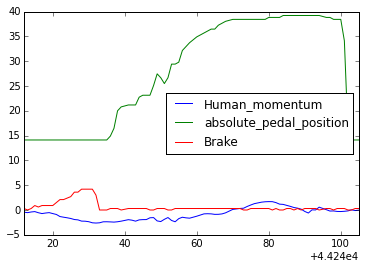

In [21]:
#superdf = pickle.load(open('../dfall_random.pkl'))
superdf = LoadDataFrame('../data/frame_data/data_frame_48.7366648289_11.4557780456_303.505703422_24.3346007605_aligned_larger.pkl')
#plotComparison(superdf,'Speed',['6','50'],[[(0,'2014-03-05')],[(0,'2014-03-26')]])
plotSession(superdf,'6','2014-03-05',0,['Human_momentum','absolute_pedal_position','Brake'])
#Picked user 35 session 0 date 2014-05-05
#47 session 2 date 2014-03-07
#plotUser(superdf,user='47',feature='Speed',sessions=[0],days=['2014-03-07'])
#plotFeature(superdf,users=['6','10','45','35'],feature='steering_wheel_angle2')